In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from statistics import mean, median
from collections import Counter
import itertools

In [2]:
locale = 'english'
stop_words = stopwords.words(locale)
print("loading {} stop words such as {}".format(locale, stop_words[:5]))
dataset = pd.read_csv('data.csv', header=None, usecols=[0,1])
dataset.columns = ['utterance', 'intent']

loading english stop words such as ['i', 'me', 'my', 'myself', 'we']


In [3]:
clean_dataset = dataset.dropna(axis=0, how='any')
print("Dataset row count : {}".format(len(clean_dataset)))
clean_dataset.describe()

Dataset row count : 10


,utterance,intent
count,10,10
unique,10,2
top,yo,coffeeshop
freq,1,6


In [4]:
def remove_stop_words(vocab):
    return [word for word in vocab if word not in stop_words]

## Find the most frequent words
- join all data from the utterances column
- remove the stop words
- use the [counter](https://pymotw.com/2/collections/counter.html) module to count the most common occurences
- use a list to collect your data, then initialise a DataFrame when you are ready, never use append if you can avoid it
 - as per the official [dataframes docs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html)
 - and as per [some guy](https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it) on stackoverflow


In [5]:
complete_vocab = " ".join(clean_dataset["utterance"]).split(' ') 

clean_vocab = remove_stop_words(complete_vocab)
print("Word count reduced from {} to {}".format(len(complete_vocab), len(clean_vocab)))
counter = Counter(clean_vocab)
top_words = counter.most_common(10)

word_count = []
for top_word in top_words:
    word_count.append({"word": top_word[0], "count": top_word[1]}) 
   
word_count_df=pd.DataFrame(word_count,columns=['word','count'])


Word count reduced from 39 to 24


## Create a barchart showing frequency across all intents

Most frequent word is coffee


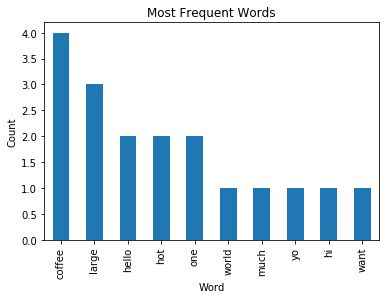

In [6]:
print("Most frequent word is {}".format(top_words[0][0]))
fig, ax = plt.subplots()
word_count_df.sort_values(by="count",ascending=False)['count'].plot.bar();
ax.set_xticklabels(word_count_df.sort_values(by="count",ascending=False)['word'])
plt.title("Most Frequent Words")
plt.ylabel("Count")
plt.xlabel("Word")
plt.show()

## group the intents and get a count of how many utterances each intent has

In [10]:
grouped_dataset = clean_dataset.groupby(['intent'])
grouped_dataset.groups.keys()
grouped_dataset.count()

,utterance
intent,
coffeeshop,6
greeting,4


## display the distribution of utterances across intents as a pie chart

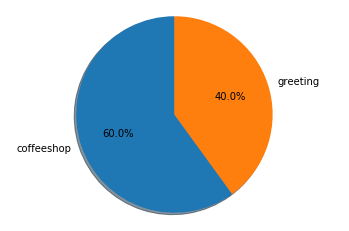

In [11]:
fig1, ax1 = plt.subplots()
labels = grouped_dataset.groups.keys()
sizes = grouped_dataset.count()["utterance"]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Generate some statistics about each intent
- iterate the intents
- create a list of all the words associated with each intent (removing stop words)
- produce a new dataframe displaying details about each intent
 - intent name
 - number of utterances associated with the intent
 - number of words in longest utterance associated with the intent
 - number of words in shortest utterance associated with the intent
 - average number of words per utterance associated with the intent
 - median number of words per utterances associated with the intent

In [13]:
word_count = lambda sentence: len(word_tokenize(sentence))
top_words_by_intent = []
my_list = []

for name, group in grouped_dataset:
    # create a single vocab from all the utterances associated with this intent
    group_vocab = " ".join(group["utterance"]).split(" ")
    clean_group_vocab = remove_stop_words(group_vocab)
    group_counter = Counter(clean_group_vocab)
    # get the top 3 most frequent words associated with this intent
    most_common_in_group = group_counter.most_common(3)
    # this will make creating a graphical representation much easier later
    top_words_by_intent.append({
        "intent": name, 
        "top": list(map(lambda x: x[0], most_common_in_group)),
        "1": most_common_in_group[0],
        "2": most_common_in_group[1],
        "3": most_common_in_group[2]
    })
    my_list.append({"intent_name": name, 
                    "utterances": len(group),
                    "max_words_ut": len(max(group["utterance"], key=word_count).split(' ')),
                    "min_words_ut": len(min(group["utterance"], key=word_count).split(' ')),
                    "avg" : mean(list(map(lambda x: len(x.split(' ')), group["utterance"]))),
                    "median" : median(list(map(lambda x: len(x.split(' ')), group["utterance"]))),
                   }) 
   

dfx=pd.DataFrame(my_list,columns=['intent_name','utterances', 'max_words_ut','min_words_ut', 'avg', 'median'])
print(dfx.to_string())

  intent_name  utterances  max_words_ut  min_words_ut       avg  median
0  coffeeshop           6             7             3  4.833333     5.0
1    greeting           4             5             1  2.500000     2.0


## lets look at each intents top 3 words and their frequency

In [14]:
dftw=pd.DataFrame(top_words_by_intent,columns=['intent','top','1','2','3'])
print(dftw)

       intent                   top            1           2         3
0  coffeeshop  [coffee, large, hot]  (coffee, 4)  (large, 3)  (hot, 2)
1    greeting    [hello, world, yo]   (hello, 2)  (world, 1)   (yo, 1)


## format our data to be charted
because of the weird way matplotlib does [grouped bar chart](https://matplotlib.org/3.1.1/gallery/units/bar_unit_demo.html) we need to format our data a little differently, we need to have the first bar of each group together, the second bar of each group together and so forth.

the code also uses the itertools chain to concat the lists of labels, see [this](https://stackoverflow.com/questions/1720421/how-do-i-concatenate-two-lists-in-python) stackoverflow post for why this is the most efficient way to concat lists

In [50]:
def generate_labels_and_counts(data):
    labels = list(map(lambda x: x[0], data))
    counts = list(map(lambda x: x[1], data))
    return { "labels": labels, "counts": counts }

data = generate_labels_and_counts(dftw['1'].tolist())
number_one_labels = data["labels"]
number_ones = data["counts"]

data = generate_labels_and_counts(dftw['2'].tolist())
number_two_labels = data["labels"]
number_twos = data["counts"]

data = generate_labels_and_counts(dftw['3'].tolist())
number_three_labels = data["labels"]
number_threes = data["counts"]

top_three_list = [number_ones, number_twos, number_threes]
top_three_labels = [number_one_labels, number_two_labels, number_three_labels]
# https://stackoverflow.com/questions/1720421/how-do-i-concatenate-two-lists-in-python
labels = list(itertools.chain.from_iterable(top_three_labels))

# formatted data for our grouped bar charts
print(top_three_list)
print(labels)

[[4, 2], [3, 1], [2, 1]]
['coffee', 'hello', 'large', 'world', 'hot', 'yo']


## lets finally graph the most frequent words per intent

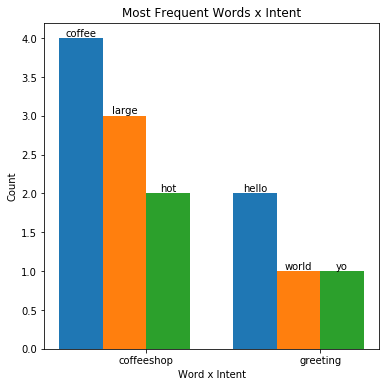

In [57]:
intents = dftw["intent"]

number_groups = len(intents)+1
bin_width = 1.0/(number_groups+1)
fig, ax = plt.subplots(figsize=(6,6))
for i in range(number_groups):
    ax.bar(x=np.arange(len(intents)) + i*bin_width, 
           height=top_three_list[i],
           width=bin_width,
           align='center')
ax.set_xticks(np.arange(len(categorical_1)) + number_groups/(2*(number_groups+1)))
ax.set_xticklabels(intents)

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title("Most Frequent Words x Intent")
plt.ylabel("Count")
plt.xlabel("Word x Intent")
plt.show()